# replicate the sine model to check if we can deploy the model onto the MCU

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import math

### check if mps support is available -metal performance shaders

In [5]:
torch.backends.mps.is_available()

True

In [6]:
torch.backends.mps.is_built()

True

In [36]:
# we can use it by setting the mps device
mps = torch.device("mps")
cpu = torch.device("cpu")

## create data 

In [9]:
SAMPLES = 1000
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

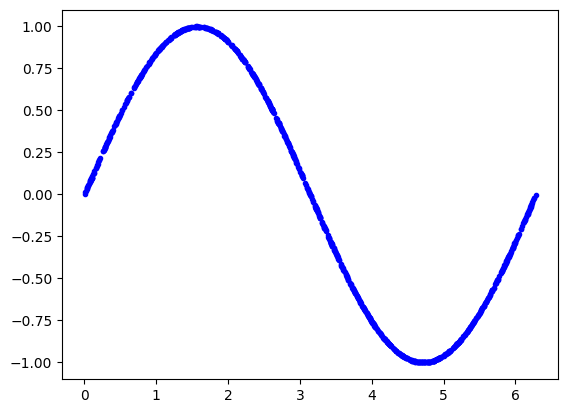

In [13]:
# generate random numbers
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# shuffle the values
np.random.shuffle(x_values)

# calculate corresponding y values
y_values = np.sin(x_values)
plt.plot(x_values, y_values, 'b.')
plt.show()

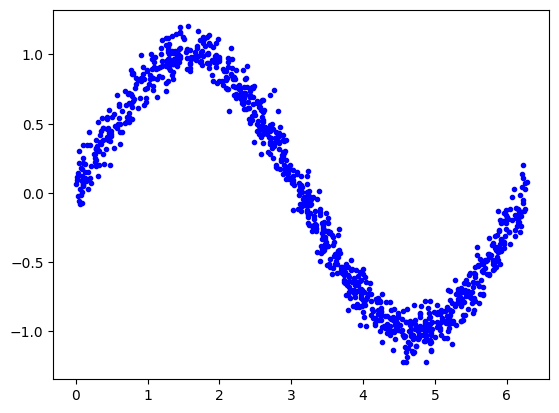

In [18]:
# add noise
y_values += 0.1 * np.random.randn(y_values.shape[0])

plt.plot(x_values, y_values, 'b.')
plt.show()

In [19]:
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

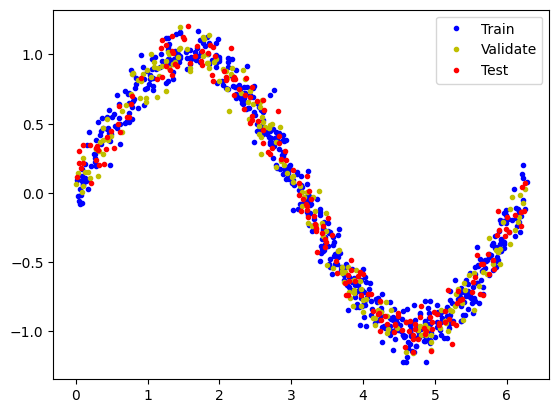

In [20]:
# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

# model

In [26]:
# shape should resemble the one used in the tensorflow tutorial

class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        # input layer
        self.fc1 = nn.Linear(1, 16)
        # hidden layer
        self.fc2 = nn.Linear(16, 16)
        # output layer, no activation
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        # forward loop to propagate through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

mlp_3 = mlp()
print(mlp_3)

mlp(
  (fc1): Linear(in_features=1, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


In [27]:
params = list(mlp_3.parameters())
print(len(params))
print(params[0].size())

6
torch.Size([16, 1])


In [74]:
EPOCHS = 10
LR = 0.01

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

In [79]:
def train(model, opti, crit, device, train_data, val_data):
    train_loss = list()
    val_loss = list()
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_train_loss = list()
        
        for x_train, y_train in train_data:
            x_train = torch.tensor(x_train).to(device)
            y_train = torch.tensor(y_train).to(device)
            
            opti.zero_grad()
            # make prediction
            output = model(x_train)
            # compute loss
            loss = crit(input=output, target=y_train)
            loss.required_grad = True
            # backward pass
            loss.backward()
            # optimization step
            opti.step()
            
            epoch_train_loss.append(loss.detach().cpu().numpy())

        train_loss.append(np.average(epoch_train_loss))
        
        model.eval()
        epoch_val_loss = list()
        
        for x_val, y_val in val_data:
            x_val = torch.tensor(x_val).to(device)
            y_val = torch.tensor(y_val).to(device)
            #prediction
            output = model(x_val)
            # compute loss
            loss = criterion(input=output, target=y_val)
            
            epoch_val_loss.append(loss.detach().cpu().numpy())
        
        val_loss.append(np.average(epoch_val_loss))
        
        print(f"Train loss is {train_loss[-1]}")
        print(f"Validation loss is {val_loss[-1]}")

    return model

In [82]:
torch.tensor(x_train[0])

tensor(5.6952, dtype=torch.float64)

In [91]:
torch.randn(16)

tensor([ 1.5574,  2.0379, -0.1133, -1.0065, -0.6233,  1.0608,  1.1780,  0.3302,
         1.0225,  0.7758,  0.6460,  0.7403,  1.3117, -1.9452,  1.7431,  0.2429])

In [86]:
torch.tensor(y_train[0])

tensor(-0.5409, dtype=torch.float64)

In [80]:
%%time
train(mlp_3, optimizer, criterion, cpu, 
      zip(x_train, y_train), zip(x_validate, y_validate))

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D